# Numerical Solution of the growth in time of a longitudinal crack 

Using the data from the paper (Jiang et al., 2017) [Paper 83]

* N = 14	day

* C = 2.2E-12	m/cycle

* dP= Pmax - Pmin = 0.52-0.39 = 0.13	Pa

* m=6.4	

* D=0.5	m

* t=0.015	m

* lcritical = 0.3 m

In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd

#universal constants
g=9.81 #m/s²
ro= 1000 #kg/m³

#criteria for the output
detectableFlow = 0.250/3600 #m3/h

#delta time of one day 
deltaT = 1


In [2]:
#density of water and gravity have to be predefined
def getMLongFAVAD(lf,Dint,E,t):
    
    return (2.93157*(Dint**0.3379)*(lf**4.8)*(10**(0.5997*(math.log(lf,10)**2)))*ro*g)/(E*(t**1.746))
           
def convertmToMPa(pressureInm):
    
    return pressureInm * ro * g / (10 ** 6)

def convertMPaTom(pressureInMPa):
    
    return pressureInMPa * (10 ** 6)/(ro * g)


In [3]:
def createSensivilityRanges():
    
    #FAVAD constants (min, typical, max, name)
    widths = [0.00001, 0.001, 0.05, "widthC"]# m  (min from paper 012)
    Cds = [0.5, 0.65, 0.8, "Cd"] #dimensionless (from paper 007)

    EModulus = [300000000, 1000000000, 207000000000, "E"] #GPa (from excel material properties)
    CsParis = [10**-13, 2.2*10**(-12), 10**-3, "Cparis"] # (aprox from equation and Book C001)
    msParis = [2, 6.4, 9, "mParis"] # (aprox from equation and Book C001)

    thicks = [0.0003, 0.011, 0.015, "thickness"] #m (from paper 012, 001, 98)
    Dsint = [0.010, 0.1, 0.9, "Dint"]#m (aprox from data wPipesGISNfailures[['NOM_DIA_MM']])

    crackLenghs= [0.020, 0.1, 0.300, "cLenght"] #m (assumtion)

    Ncycles= [1, 2, 14, "N"] #cycle per day (assumption)
    PressuresMin = [0, 20 , 100, "PMin"] #mca
    PressuresMax = [100, 150 ,400, "PMax"] #mca

    #list of variable variables
    iterables = [widths,Cds,EModulus,CsParis,msParis,thicks,Dsint,crackLenghs,Ncycles,PressuresMax,PressuresMin]
                
    return iterables


# Standard Values 
def getCurrentValsDict(widthC,Cd,E,Cparis,mParis,thickness,Dint,cLenght,N,Pmax,Pmin):
    
    currentVals = { "widthC": widthC, #m
                   "Cd": Cd, #dimensionless
                   "E": E, # 
                   "Cparis": Cparis,
                   "mParis": mParis,
                   "thickness": thickness, #m
                   "Dint": Dint, #m
                   "cLenght" : cLenght,
                   "N" : N,
                   "PMax" : Pmax,
                   "PMin" : Pmin
        }
    
    return currentVals

#change to calculate lcritial
#lcritical =0.300


In [4]:
#Uses Pmax for the flow (i.e. minimum night flow)
# Pressures in meters column of water
def createCurveUntilDetectable(widthC,Cd,E,Cparis,Mparis,t,Dint,lo,nCicles,Pmax,Pmin):

    #initialization 
    li = lo
    Timef = 0
    D= Dint
    Q= 0
    critical = False
    times = []
    flows = []
    
    
    #gets the pressure and pressure difference in the necessary units for TADA and FAVAD eq
    deltaP= convertmToMPa(Pmax-Pmin)
    h= Pmax

    #Euler
    while Q < (29793):

        #Paris Law------------------------------------------------------------------
        
        #calculation of the geometric factor (from Tada)
        lam = li/(D*t/2)**0.5
        if lam <= 1:
            Y = (1+1.25* lam**2)**0.5   
        elif lam <= 5:
            Y = 0.6 + (0.9 * lam)
        else:
            critical = True
            Q = detectableFlow
            break
            
        
        #calculation of delta K
        deltaK = deltaP * D / (2*t) * Y * (math.pi * li)**0.5

        #Final lenght of the crack
        nCiclesPerIter = deltaT * nCicles
        lf = (Cparis * deltaK**Mparis )* nCiclesPerIter + li

        
        # FAVAD--- from paper 012---------------------------------------------------
        leakArea = lf*widthC
        
        mFAVAD = getMLongFAVAD(lf,Dint,E,t)
        
        Q = Cd*((2*g)**0.5)*(leakArea*(h**0.5)+mFAVAD*(h**1.5))

        flows.append(Q)
        times.append(Timef)
        
        li = lf
        Timef += deltaT
        
        if (Timef/365)>200:
            print("Too Slow")
        
    return critical,lam,Y,deltaK,nCiclesPerIter,lf,Y,leakArea,mFAVAD,Q,li,lf, widthC,Cd,E,Cparis,Mparis,t,Dint,lo,nCicles,Pmax,Pmin

In [5]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

In [6]:
va = createSensivilityRanges()

v = 2

#Typical diameter and thickess
#Smaller diameters "in theory" gives slower cracks growths
thickness = 0.01 #va[5][1]
diam = 0.15 #va[6][1]

#HighValues for the rest of values
#Change between typical E and high E is nothing in strenght index
cVals = getCurrentValsDict(va[0][v],va[1][v],va[2][v],va[3][v],va[4][v],va[5][v],
                           va[6][v],va[7][v],va[8][v],va[9][v],va[10][v])

#crack lenght and width in m
cLenght= 0.001
widthC = 0.001

#From Auckland Data 70 and 150
PMaxAve= 70
PMaxMax= 150

#Fluctuation mean 7m and max 35m in Auckland
PminAve= 20 #50 fluct
PminMax = 100  #50 fluct
PminMaxFluctAve = 15 #55 fluct
PminMaxFluct = 95 #55 fluct

PmaxRef=va[9][2]
PminRef=va[10][2]
         

label1 = "Pmax:"+ str(PMaxAve) + ", fluc:" + str(PMaxAve-PminAve)
critical,lam,Y,deltaK,nCiclesPerIter,lf,Y,leakArea,mFAVAD,Q,li,lf, widthC,Cd,E,Cparis,Mparis,t,Dint,lo,nCicles,Pmax,Pmin= createCurveUntilDetectable(widthC,cVals["Cd"],cVals["E"],cVals["Cparis"]
                                                    ,cVals["mParis"],thickness,diam,
                                                    cLenght,cVals["N"],PMaxAve,PminAve)


In [8]:
Q

0.00047993287113381756

In [9]:
#calculation of the geometric factor (from Tada)
deltaP= convertmToMPa(Pmax-Pmin)
h= Pmax

print("Lam old ",lam, "Lamb new: ")
lam = li/(diam*t/2)**0.5
print(lam," YOld ", Y ," Ynew: ")
if lam <= 1:
    Y = (1+1.25* lam**2)**0.5   
elif lam <= 5:
    Y = 0.6 + (0.9 * lam)
else:
    critical = True
    Q = detectableFlow if Q<detectableFlow else Q
    print("CRITICAL!!")
    
print(Y," deltaK ", deltaK, " new deltaK: ")

#calculation of delta K
deltaK = deltaP * diam / (2*t) * Y * (math.pi * li)**0.5

print(deltaK," ncicles ", nCiclesPerIter, " new cicles: ")
#Final lenght of the crack
nCiclesPerIter = deltaT * nCicles
print(nCiclesPerIter," lf ", lf, "new Lf: ")
lf = (Cparis * deltaK**Mparis )* nCiclesPerIter + li
print(lf," leakArea ", leakArea, "new Larea: ")

# FAVAD--- from paper 012---------------------------------------------------
leakArea = lf*widthC
print(leakArea," mFav ", mFAVAD, "new mfav: ")


mFAVAD = getMLongFAVAD(lf,diam,E,t)
print(mFAVAD," Q ", Q, " new Q: ")


Q = Cd*((2*g)**0.5)*(leakArea*(h**0.5)+mFAVAD*(h**1.5))
print(Q," li ", li, " new li: ", lf)


li = lf

Lam old  0.47785833557212587 Lamb new: 
0.5909772059653755  YOld  1.1337705835373852  Ynew: 
1.1985689685885006  deltaK  0.8456979835337816  new deltaK: 
0.9942347125946441  ncicles  14  new cicles: 
14  lf  0.01618457733393064 new Lf: 
0.02947467992555787  leakArea  1.618457733393064e-05 new Larea: 
2.9474679925557872e-05  mFav  4.825199438371323e-11 new mfav: 
2.597793936714882e-10  Q  0.00047993287113381756  new Q: 
0.0008743905670901902  li  0.01618457733393064  new li:  0.02947467992555787


In [10]:
#calculation of the geometric factor (from Tada)
deltaP= convertmToMPa(Pmax-Pmin)
h= Pmax

print("Lam old ",lam, "Lamb new:")
lam = li/(diam*t/2)**0.5
print(lam," YOld ", Y ," Ynew :")
if lam <= 1:
    Y = (1+1.25* lam**2)**0.5   
elif lam <= 5:
    Y = 0.6 + (0.9 * lam)
else:
    critical = True
    Q = detectableFlow
    print("CRITICAL!!")
    
print(Y," deltaK ", deltaK)

#calculation of delta K
deltaK = deltaP * diam / (2*t) * Y * (math.pi * li)**0.5

print(deltaK," ncicles ", nCiclesPerIter)
#Final lenght of the crack
nCiclesPerIter = deltaT * nCicles
print(nCiclesPerIter," lf ", lf)
lf = (Cparis * deltaK**Mparis )* nCiclesPerIter + li
print(lf," leakArea ", leakArea)

# FAVAD--- from paper 012---------------------------------------------------
leakArea = lf*widthC
print(leakArea," mFav ", mFAVAD)


mFAVAD = getMLongFAVAD(lf,diam,E,t)
print(mFAVAD," Q ", Q)


Q = Cd*((2*g)**0.5)*(leakArea*(h**0.5)+mFAVAD*(h**1.5))
print(Q," li ", li, " li2 ", lf)


li = lf

Lam old  0.5909772059653755 Lamb new:
1.0762631380315157  YOld  1.1985689685885006  Ynew :
1.5686368242283641  deltaK  0.9942347125946441
1.755990517193418  ncicles  14
14  lf  0.02947467992555787
2.2519018207433033  leakArea  2.9474679925557872e-05
0.0022519018207433033  mFav  2.597793936714882e-10
0.01327929195583249  Q  0.0008743905670901902
27.62563723993962  li  0.02947467992555787  li2  2.2519018207433033


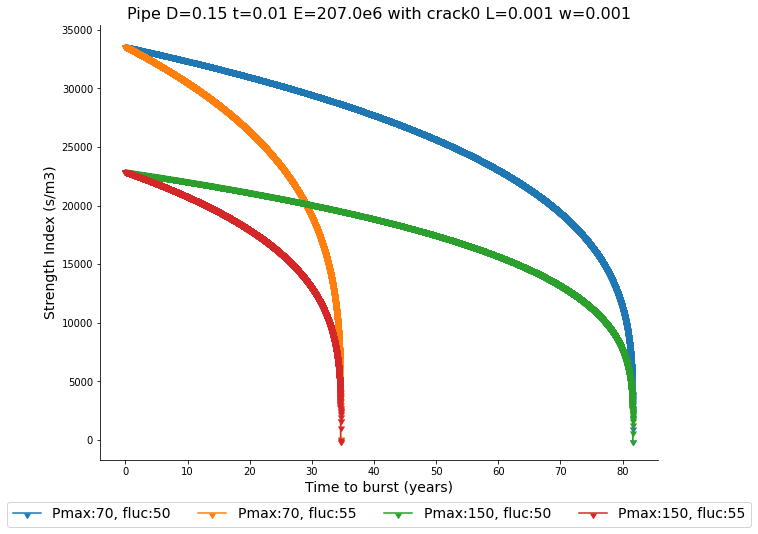

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

for t,f,l in zip([times,times4,times2,times3],[flows,flows4,flows2,flows3],[label1,label4,label2,label3]):
    
    timesY = [x / 365 for x in t]
    flowsP = [1 / x for x in f]
    
    ax.plot(timesY,flowsP,label=l,marker=11)  


title = ('Pipe D='+ str(diam) + ' t=' + str(thickness) + ' E=' + str(cVals["E"]/1000000000) +
        "e6 with crack0 L=" + str(cLenght) + " w=" + str(widthC) )
    
ax.set_title(title,fontsize=16)
ax.set_ylabel('Strength Index (s/m3)',fontsize=14)
ax.set_xlabel('Time to burst (years)',fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=14)
ax= removeTopRightFrame(ax)

#fig.savefig('Maps_Graph/CrackGrowthAnalysis/'+'Pipe1' +'.jpg', dpi=200, bbox_inches='tight')




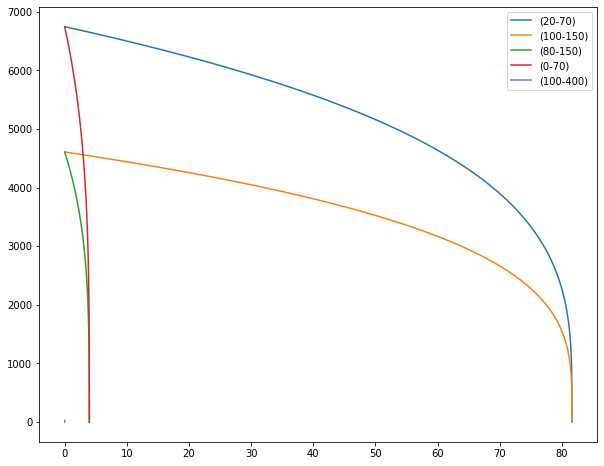

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

for t,f,l in zip([times,times2,times3,times4,timesRef],[flows,flows2,flows3,flows4,flowsRef],[label1,label2,label3,label4,labelRef]):
    
    timesY = [x / 365 for x in t]
    flowsP = [1 / x for x in f]
    
    ax.plot(timesY,flowsP,label=l)  
    ax.legend()
   
    

In [44]:
[critical,critical1,critical2,critical3]

[False, False, False, False]

# -------Start of new graph and analysis --------------------------------------

In [15]:
finVals = []
indexValues = [0,1,3,4,2]
labels = ['Very low', 'Low', 'High', 'Very high', 'Typical']
va = createSensivilityRanges()

cVals = getCurrentValsDict(va[0][1],va[1][1],va[2][1],va[3][1],va[4][1],va[5][1],
                           va[6][1],va[7][1],va[8][1],va[9][1],va[10][1])
                                    
for v in va:
    
    vMin, vTypical, vMax, name = v[0], v[1], v[2] ,v[3]
    
    int1 = vMin + (vTypical - vMin)/2
    int2 = vTypical + (vMax - vTypical)/2

    for val, i in zip([vMin, int1, int2, vMax, vTypical], indexValues):
         
        cVals[name] = val
        N = cVals["N"]
        
        timeDetectable, critical, t ,f = createCurveUntilDetectable(cVals["widthC"],cVals["Cd"],cVals["E"],cVals["Cparis"]
                                                    ,cVals["mParis"],cVals["thickness"],cVals["Dint"],
                                                    cVals["cLenght"],N,cVals["PMax"],cVals["PMin"])
        
        
        finVals.append([val, name, timeDetectable, N, critical, i])

results = pd.DataFrame(finVals, columns=['Value', 'Variable', 'CriticalCycles', 'N','CriticalLength','index'])
results['Time (year)'] = results['CriticalCycles']/(365*results['N'])
results.set_index('Variable',inplace= True)


fig, ax = plt.subplots(1, figsize=(10, 8))
for var in results.index.unique():
    
    resVar = results.loc[var]
    ax.plot(resVar['index'],resVar['Time (year)'],label=var,marker='+',markersize=12)

    
ax.set_ylim(0,100)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)




KeyboardInterrupt: 

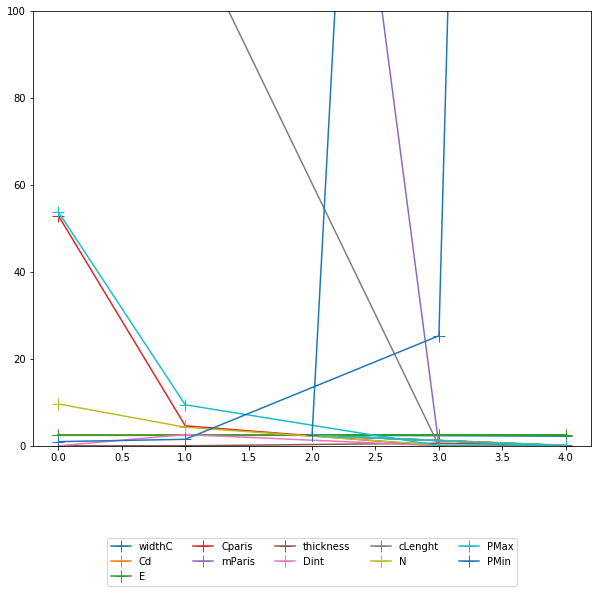

In [7]:
results

,Value,Variable,CriticalCycles,N,CriticalLength,index,Time (year)
0,1.000000e-05,widthC,1757,2.0,True,0,2.406849
1,5.050000e-04,widthC,1757,2.0,True,1,2.406849
2,2.550000e-02,widthC,1757,2.0,True,3,2.406849
3,5.000000e-02,widthC,1693,2.0,False,4,2.319178
4,1.000000e-03,widthC,1757,2.0,True,2,2.406849
5,5.000000e-01,Cd,1757,2.0,True,0,2.406849
6,5.750000e-01,Cd,1757,2.0,True,1,2.406849
7,7.250000e-01,Cd,1757,2.0,True,3,2.406849
8,8.000000e-01,Cd,1757,2.0,True,4,2.406849
9,6.500000e-01,Cd,1757,2.0,True,2,2.406849


Text(0, 0.5, 'Q(m3/s)')

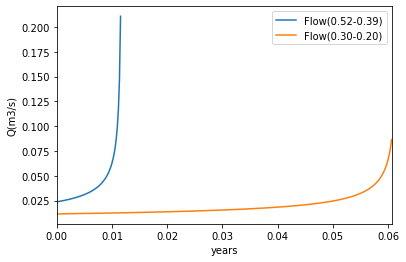

In [15]:
#graph
vals, valsW = createCurve(Dint,E,t,lo,Cparis,nCicles,0.52,0.39,False)
df = pd.DataFrame(vals, columns=['cycles','Flow(0.52-0.39)'])
df['years']=df['cycles']/(365*N)
ax = df.plot(x='years',y='Flow(0.52-0.39)')

vals2, valsW = createCurve(Dint,E,t,lo,Cparis,nCicles,0.30,0.20,False)

df2 = pd.DataFrame(vals2, columns=['cycles','Flow(0.30-0.20)'])
df2['years']=df2['cycles']/(365*N)
df2.plot(x='years',y='Flow(0.30-0.20)', ax=ax)


ax.set_ylabel('Q(m3/s)')

In [1]:
#graph
vals, valsW = createCurve(Dint,E,t,lo,Cparis,nCicles,0.52,0.39,False)
df = pd.DataFrame(vals, columns=['cycles','Flow(0.52-0.39)'])
df['years']=df['cycles']/(365*N)
ax = df.plot(x='years',y='Flow(0.52-0.39)')

vals2, valsW = createCurve(Dint,E,t,lo,Cparis,nCicles,0.30,0.20,False)

df2 = pd.DataFrame(vals2, columns=['cycles','Flow(0.30-0.20)'])
df2['years']=df2['cycles']/(365*N)
df2.plot(x='years',y='Flow(0.30-0.20)', ax=ax)


ax.set_ylabel('Q(m3/s)')

NameError: name 'createCurve' is not defined

Text(0, 0.5, 'a(m)')

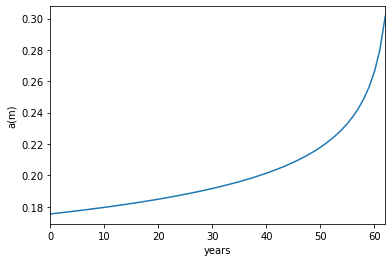

In [31]:
#graph
df = pd.DataFrame(curveVals, columns=['cycles','Crack lenght'])
df['years']=df['cycles']/(365*N)
ax = df.plot(x='years',y='Crack lenght', legend=False)
ax.set_ylabel('a(m)')
    

## OLD---------------------------------------------------------------------------------

In [14]:
#Uses Pmax for the flow (i.e. minimum night flow)
def createCurve(Dint,E,t,lo,Cparis,nCicles,Pmax,Pmin,meters):

    #initialization 
    li = lo
    curveVals = []
    curveQVals = []
    Timef = 0
    D= (Dint + (Dint + t))/2
    
    
    #gets the pressure and pressure difference in the necessary units for TADA and FAVAD eq
    if meters:
        deltaP= convertmToMPa(Pmax-Pmin)
        h= Pmax
    else:
        deltaP = Pmax-Pmin
        h=convertMPaTom(Pmax)
    

    #Euler
    while li < lcritical:

        #Paris Law------------------------------------------------------------------
        
        #calculation of the geometric factor (from Tada)
        lam = li/(D*t/2)**0.5
        if lam <= 1:
            Y = (1+1.25* lam**2)**0.5   
        elif lam <= 5:
            Y = 0.6 + (0.9 * lam)
            
        
        #calculation of delta K
        deltaK = deltaP * D / (2*t) * Y * (math.pi * li)**0.5

        #Final lenght of the crack
        lf = (Cparis * deltaK**m )* nCicles + li

        curveVals.append([Timef,lf])

        # FAVAD--- from paper 012---------------------------------------------------
        leakArea = lf*widthC
        
        mFAVAD = getMLongFAVAD(lf,Dint,E,t)
        
        Q = Cd*((2*9.81)**0.5)*(leakArea*(h**0.5)+mFAVAD*(h**1.5))

        curveQVals.append([Timef,Q])                       

        #print(Timef,"-",li,"-",lam,"-",lf,"-",mFAVAD,"-",Y,"-",deltaK,"-",Q)
        
        li = lf
        Timef += deltaT
        
        
    return curveQVals, curveVals


In [5]:
Dint= 0.1 #mm
cd=0.65
E = 4000000000 #pa
t= 0.02 #m
lf=0.005 #m (3 cm)

In [6]:
widthC= 0.001

mF1 = getMLongFAVAD(lf,Dint,E,t)
leakArea = lf*widthC
getPressureToBeDiscover(cd, mF1, leakArea, detectableFlow)

NameError: name 'getPressureToBeDiscover' is not defined